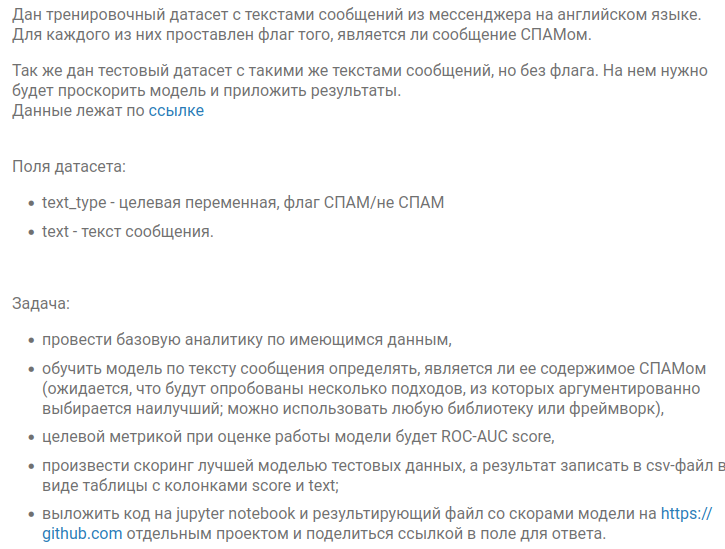

# Imports

In [1]:
!pip install textstat datasets evaluate
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 7.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from itertools import groupby
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import PorterStemmer
from textstat import flesch_reading_ease

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
from torch.nn import functional as F
import torch


nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
test = pd.read_csv('test_spam.csv')
train = pd.read_csv('train_spam.csv')

# EDA

### Просмотр и разделение данных

In [ ]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Пропусков нет, train в 4 раза больше test

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


(None, None)

Будем сравнивать два класса между собой, чтобы попытаться найти отличия в них. Данные несбалансированные, потому что спама меньше почти в 2.5 раза

In [ ]:
spam = train[train['text_type'] == 'spam'].loc[:, 'text']
ham = train[train['text_type'] == 'ham'].loc[:, 'text']

spam.name = 'spam',
ham.name = 'ham'

spam.shape[0], ham.shape[0]

(4809, 11469)

### Количество символов в предложении

Видим, что spam и ham расходятся в количестве совсем коротких текстов - в spam сильно меньше (по отношению к общему количеству) текстов меньше 100 символов

<Axes: >

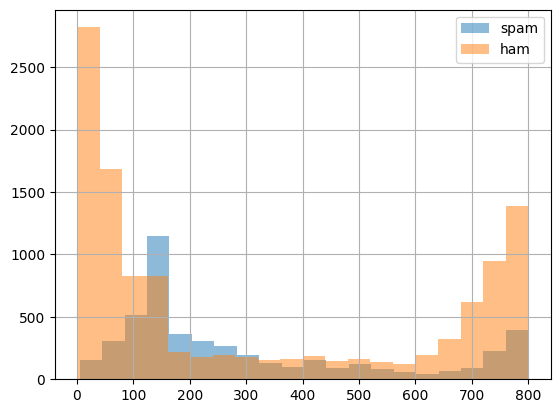

In [ ]:
spam.str.len().hist(bins=20, alpha=0.5, legend=True),
ham.str.len().hist(bins=20, alpha=0.5, legend=True)

### Количество слов в предложении

По количеству слов распределения похожи, но такая же картина с слишком короткими текстами

<Axes: >

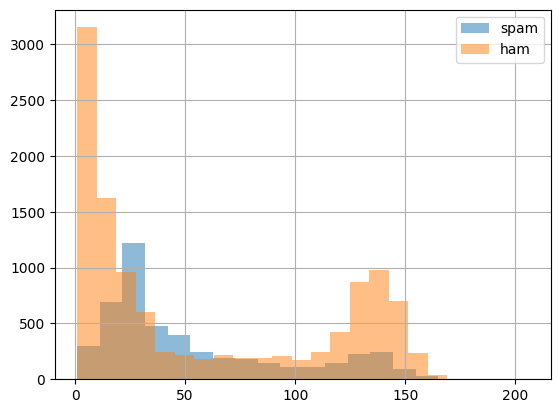

In [ ]:
spam.str.split().map(lambda x: len(x)).hist(bins=20, alpha=0.5, legend=True),
ham.str.split().map(lambda x: len(x)).hist(bins=20, alpha=0.5, legend=True)

### Количество стоп-слов

Интересно, что слово "your" не входит в топ-15 в ham - вероятно, в спаме чаще обращаются на "ты", чтобы зацепить читателя. Также, "i" встречается в спаме относительно реже - спам часто обезличенный

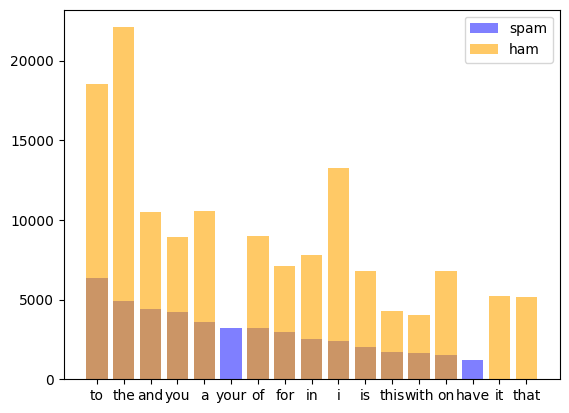

In [ ]:
new_spam = spam.str.split()
new_spam = new_spam.values.tolist()
corpus_spam = [word for i in new_spam for word in i]

new_ham = ham.str.split()
new_ham = new_ham.values.tolist()
corpus_ham = [word for i in new_ham for word in i]

dic = defaultdict(int)
for word in corpus_spam:
    if word in stop:
        dic[word] += 1

top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15]
x,y=zip(*top)
plt.bar(x,y, alpha=0.5, color='blue')

dic = defaultdict(int)
for word in corpus_ham:
    if word in stop:
        dic[word] += 1

top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15]
x,y=zip(*top)
plt.bar(x,y, alpha=0.6, color='orange')
plt.legend(["spam", "ham"])

### Топ популярных слов

Подозрительное число 1635465 приводит меня к [источнику данных на HF](https://huggingface.co/datasets/thehamkercat/telegram-spam-ham). Судя по контексту, этим числом анонимизировали числовые и текстовые sensitive данные.

В ham популярны обычные слова из деловой переписки и служебные слова из емейлов. Мне стало интересно, почему фамилия kaminski так часто встречается. Причина - данные взяты из [Public Domain Enron Email Corpus and Database](http://www.enron-mail.com/), в которой vince j kaminski являлся менеджером. Таким образом, многие частые слова в данных объясняются одними и теми же адресатами писем и компанией Enron, где они работали.

<Axes: >

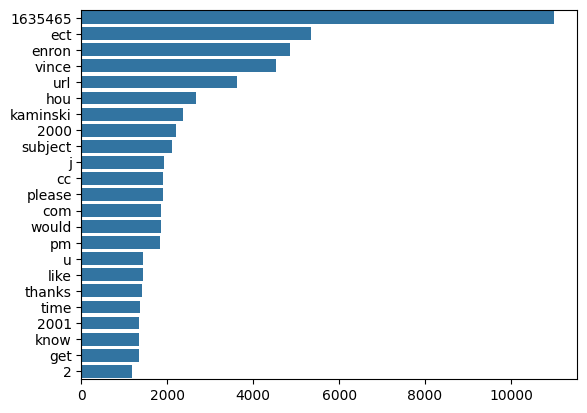

In [ ]:
counter=Counter(corpus_ham)
most=counter.most_common()

x, y= [], []
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

В спаме имен не наблюдается. В основном попадаются слова, связанные с рекламой, побуждениями к действию и понятиями, ассоциирующимися с успехом (как money, best, business).

<Axes: >

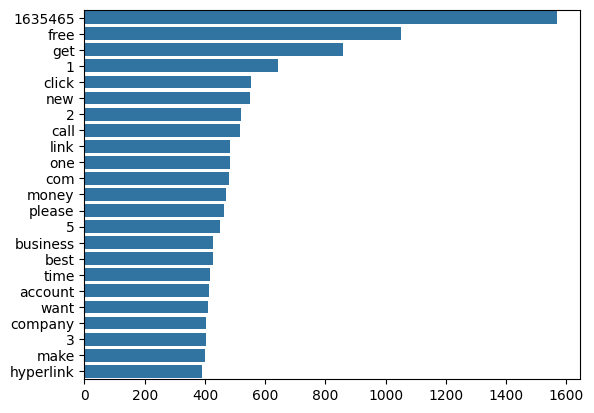

In [ ]:
counter=Counter(corpus_spam)
most=counter.most_common()

x, y= [], []
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

### Топ биграмм

Видим, что в ham почти нет повторяющихся биграмм. Зато в spam повторяющиеся биграммы присутствуют, но в сравнении с объемом датасета это ничего не дает.

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]

get_top_ngram(corpus_ham, 2)

[('81 607', 11),
 ('we re', 3),
 ('byk car', 2),
 ('movie series', 2),
 ('wife gf', 2),
 ('girl guy', 2),
 ('05 52', 1),
 ('hunter gatherers', 1),
 ('song guess', 1),
 ('you re', 1),
 ('jatt baki', 1),
 ('mirror4 mirrortd4bot', 1),
 ('unsubaâ way2sms', 1),
 ('wwho why', 1),
 ('why what', 1)]

In [ ]:
get_top_ngram(corpus_spam, 2)

[('movie series', 15),
 ('mobile laptop', 10),
 ('yes noall', 7),
 ('yes noreply', 7),
 ('13k bln', 7),
 ('paisa sms', 6),
 ('you re', 5),
 ('sms day', 5),
 ('rs2 min', 5),
 ('you ve', 5),
 ('15k bln', 5),
 ('100 𝐡𝐨𝐮𝐫', 4),
 ('promo promo', 4),
 ('𝐲𝐨𝐮 𝐫𝐞', 3),
 ('days unitech', 3)]

### Анализ сложности текстов

Сравниваем читабельность текстов в ham и spam. Ничего не дает, все примерно одинаковое.

53.55


<Axes: >

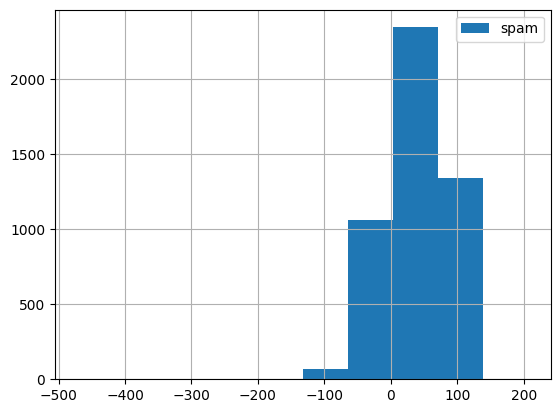

In [ ]:
print(spam.apply(lambda x : flesch_reading_ease(x)).median())
spam.apply(lambda x : flesch_reading_ease(x)).hist(legend=True)

59.64


<Axes: >

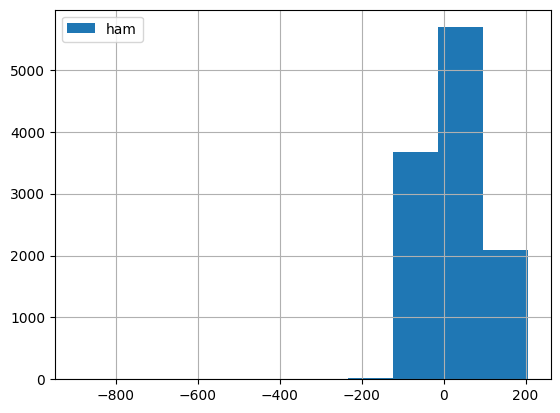

In [ ]:
print(ham.apply(lambda x : flesch_reading_ease(x)).median())
ham.apply(lambda x : flesch_reading_ease(x)).hist(legend=True)

### Количество эмодзи в тексте

Быстрый просмотр spam показал, что в текстах много эмодзи (в отличие от ham). Проверим эту гипотезу. Видим, что действительно в spam сильно больше эмодзи, но при большом размере датасета их количество невелико и не поможет

In [ ]:
spam.apply(lambda s: len(re.findall(r'[\U0001f600-\U0001f650]', s))).value_counts()

(spam,)
0     4616
1       79
2       52
3       16
4       13
5        7
6        7
9        4
10       3
33       3
7        2
8        2
12       2
28       1
20       1
11       1
Name: count, dtype: int64

In [ ]:
ham.apply(lambda s: len(re.findall(r'[\U0001f600-\U0001f650]', s))).value_counts()

ham
0    11439
1       19
2        7
3        2
4        2
Name: count, dtype: int64

### Количество повторяющихся символов

Также кажется, что в spam часто много повторяющихся символов (подряд) в одном предложении. Проверим. В spam действительно много повторяющихся символов в текстах. Смотрим только на повторы больше 2-х подряд символов (иначе это могут быть случайные повторы пробелов или слова с повторяющимися буквами в языке). В spam тройной и более повтор содержат почти 40% текстов, тогда как в ham всего 15%.

In [ ]:
def max_consecutive(s):
  groups = groupby(s)
  result = [sum(1 for _ in group) for label, group in groups]

  return max(result)

In [ ]:
spam.apply(lambda s: max_consecutive(s)).value_counts() / spam.shape[0] * 100

(spam,)
2     59.409441
3     20.128925
4      6.571013
1      2.973591
5      2.973591
6      1.954668
7      1.725931
9      0.873362
8      0.686213
10     0.561447
11     0.457476
12     0.353504
13     0.291121
17     0.270326
16     0.207943
15     0.207943
14     0.166355
18     0.062383
20     0.041589
22     0.041589
21     0.020794
35     0.020794
Name: count, dtype: float64

In [ ]:
ham.apply(lambda s: max_consecutive(s)).value_counts() / ham.shape[0] * 100

ham
2     65.960415
1     18.702590
3     13.994245
4      0.540588
5      0.261575
11     0.156945
10     0.139506
8      0.087192
7      0.061034
6      0.052315
27     0.008719
16     0.008719
21     0.008719
14     0.008719
9      0.008719
Name: count, dtype: float64

# Naive Bayes

Попробуем классику

In [5]:
def process(text):
    text = text.lower()
    text = ''.join([t for t in text if t not in string.punctuation])
    text = [t for t in text.split() if t not in stopwords.words('english')]
    st = PorterStemmer()
    text = [st.stem(t) for t in text]
    return text

Превращаем тексты в вектора через TF-IDF, убирая стоп-плова и пунктуацию и получая начальные формы из каждого слова (stemming)

In [6]:
spam_filter = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=process)),
    ('classifier', MultinomialNB())
])

Используем кросс-валидацию (stratified т.к. классы не сбалансированные) для оценки качества модели

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(spam_filter, train['text'], train['text_type'], cv=skf, scoring='roc_auc')

Среднее по 5 фолдам - 0.949, что очень даже хорошо для простой модели

In [8]:
print(cv_scores)
print(cv_scores.mean())

[0.94958012 0.94896431 0.94121246 0.94950293 0.95490887]
0.9488337362094622


# LSTM

Попробуем LSTM как типичную модель для текстовых последовательностей.

In [95]:
train['text_length'] = train['text'].apply(len)
train['label'] = train['text_type'].map({'ham':0, 'spam':1})
train.head()

,text_type,text,label,text_length
0,ham,make sure alex knows his birthday is over in f...,0,86
1,ham,a resume for john lavorato thanks vince i will...,0,520
2,spam,plzz visit my website moviesgodml to get all m...,1,126
3,spam,urgent your mobile number has been awarded wit...,1,139
4,ham,overview of hr associates analyst project per ...,0,733


Задаем параметры модели, ограничиваем размер словаря для исключения редких слов

In [96]:
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = 1000
embedding_dim = 16

Создаем модель

In [97]:
n_lstm = 128
drop_lstm = 0.2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(drop_lstm))
model.add(LSTM(n_lstm, return_sequences=False))
model.add(Dropout(drop_lstm))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 16)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 90369 (353.00 KB)
Trainable params: 90369 (353.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Компилируем и выбираем метрику ROC AUC

In [98]:
model.compile(loss = 'binary_crossentropy',
               optimizer = Adam(),
               metrics = [AUC()])

Обучаем модель, StratifiedKFold для сбалансированного разбиения, добавляем раннюю остановку если лосс перестал уменьшаться

In [99]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_epochs = 10
histories = []

X, y = train['text'], train['label']
for train_index, test_index in skf.split(X, y):
    print("-----------------------------")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    tokenizer = Tokenizer(num_words = vocab_size,
                          char_level = False,
                          oov_token = oov_tok)
    tokenizer.fit_on_texts(X_train)

    training_sequences = tokenizer.texts_to_sequences(X_train)
    training_padded = pad_sequences(training_sequences,
                                    maxlen = max_len,
                                    padding = padding_type,
                                    truncating = trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(X_val)
    testing_padded = pad_sequences(testing_sequences,
                                  maxlen = max_len,
                                  padding = padding_type,
                                  truncating = trunc_type)

    early_stop = EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit(training_padded,
                        y_train,
                        epochs=num_epochs,
                        validation_data=(testing_padded, y_val),
                        callbacks =[early_stop],
                        verbose=2)
    histories.append(history)

-----------------------------
Epoch 1/10
407/407 - 27s - loss: 0.2967 - auc_2: 0.9312 - val_loss: 0.1857 - val_auc_2: 0.9763 - 27s/epoch - 67ms/step
Epoch 2/10
407/407 - 5s - loss: 0.1852 - auc_2: 0.9703 - val_loss: 0.1930 - val_auc_2: 0.9753 - 5s/epoch - 13ms/step
Epoch 3/10
407/407 - 4s - loss: 0.1664 - auc_2: 0.9747 - val_loss: 0.1791 - val_auc_2: 0.9769 - 4s/epoch - 11ms/step
Epoch 4/10
407/407 - 3s - loss: 0.1632 - auc_2: 0.9767 - val_loss: 0.2138 - val_auc_2: 0.9710 - 3s/epoch - 9ms/step
Epoch 5/10
407/407 - 3s - loss: 0.1483 - auc_2: 0.9791 - val_loss: 0.1813 - val_auc_2: 0.9777 - 3s/epoch - 7ms/step
-----------------------------
Epoch 1/10
407/407 - 3s - loss: 0.3211 - auc_2: 0.9193 - val_loss: 0.1969 - val_auc_2: 0.9738 - 3s/epoch - 7ms/step
Epoch 2/10
407/407 - 4s - loss: 0.1880 - auc_2: 0.9712 - val_loss: 0.1810 - val_auc_2: 0.9760 - 4s/epoch - 9ms/step
Epoch 3/10
407/407 - 3s - loss: 0.1619 - auc_2: 0.9776 - val_loss: 0.1803 - val_auc_2: 0.9772 - 3s/epoch - 7ms/step
Epoch 4

Визуализируем ROC AUC по фолду с самым большим количеством эпох. Графики выглядят нормально, без переобучения. На первых эпохах val выше train из-за дропаута.

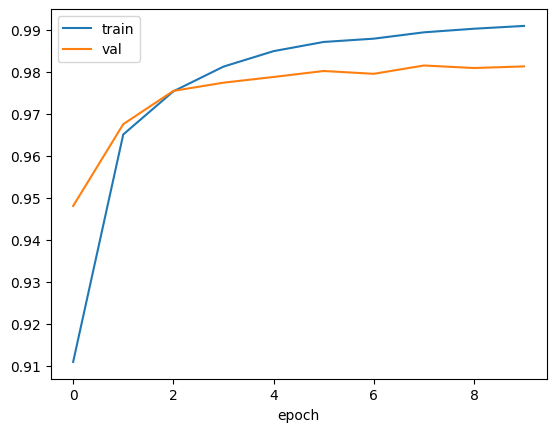

In [102]:
plt.plot(histories[4].history['auc_2'])
plt.plot(histories[4].history['val_auc_2'])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Среднее качество (имею в виду ROC AUC) выше, чем у Naive Bayes, значит LSTM предпочтительнее. Еще и работает чуть быстрее чем Naive Bayes в тех же условиях (скорее всего ранняя остановка в этом помогает)

In [104]:
[x.history['val_auc_2'][-1] for x in histories]

[0.9776872992515564,
 0.9778369665145874,
 0.9762862920761108,
 0.9700455069541931,
 0.9812210202217102]

# BERT

Используем предобученную модель BERT для классификации последовательностей. Данный блок необходимо запускать на GPU.

In [4]:
train['label'] = train['text_type'].map({'ham':0, 'spam':1})
train.head()

,text_type,text,label
0,ham,make sure alex knows his birthday is over in f...,0
1,ham,a resume for john lavorato thanks vince i will...,0
2,spam,plzz visit my website moviesgodml to get all m...,1
3,spam,urgent your mobile number has been awarded wit...,1
4,ham,overview of hr associates analyst project per ...,0


Токенайзер тоже готовый

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


На KFold будет слишком долго работать, поэтому используем обычное разбиение на train test

In [61]:
X, y = train['text'], train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

train_data = pd.concat([X_train, y_train], axis=1)
eval_data = pd.concat([X_test, y_test], axis=1)
train_dataset = Dataset.from_pandas(train_data)
eval_dataset = Dataset.from_pandas(eval_data)

In [62]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_eval = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10906 [00:00<?, ? examples/s]

Map:   0%|          | 0/5372 [00:00<?, ? examples/s]

Метрика ROC AUC

In [9]:
training_args = TrainingArguments(output_dir="test_trainer")

metric = evaluate.load("roc_auc")

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    compute_metrics=compute_metrics,
)

Обучение на GPU (T4 в Google Colab) занимает , поэтому если время обучения критично - лучше выбирать LSTM

In [12]:
trainer.train()

Step,Training Loss
500,0.244600
1000,0.178600
1500,0.113200
2000,0.062700
2500,0.051800
3000,0.035300
3500,0.025400
4000,0.020700


TrainOutput(global_step=4092, training_loss=0.08991964480394492, metrics={'train_runtime': 3249.5325, 'train_samples_per_second': 10.069, 'train_steps_per_second': 1.259, 'total_flos': 8608467509268480.0, 'train_loss': 0.08991964480394492, 'epoch': 3.0})

In [79]:
eval_dataset = Dataset.from_pandas(eval_data[['text']])
tokenized_datasets_eval= eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5372 [00:00<?, ? examples/s]

In [80]:
eval_output = trainer.predict(tokenized_datasets_eval)

In [81]:
eval_logits = torch.from_numpy(eval_output.predictions)

eval_scores = F.softmax(eval_logits, dim = -1).numpy()

In [85]:
labels = torch.argmax(torch.from_numpy(eval_scores), 1)

Получаем точность на валидации чуть поменьше, чем у LSTM. Возможно это из-за несбалансированных классов, либо при кросс-валидации мог получиться в среднем такой же скор

In [94]:
m = AUC()
m.update_state(eval_data['label'].tolist(), labels.tolist())
print(m.result())

tf.Tensor(0.96683884, shape=(), dtype=float32)


# Scoring

Так как качество выше всего у LSTM - скоринг на ней

In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 16)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 90369 (353.00 KB)
Trainable params: 90369 (353.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [109]:
test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences,
                            maxlen = max_len,
                            padding = padding_type,
                            truncating = trunc_type)

In [110]:
prediction = model.predict(test_padded)

128/128 [==============================] - 1s 5ms/step


In [115]:
prediction[:10]

array([[3.0009414e-03],
       [2.6030613e-02],
       [7.2850868e-05],
       [5.8666426e-03],
       [9.5283902e-01],
       [1.4091039e-02],
       [9.4752796e-03],
       [1.3163906e-04],
       [1.6297431e-04],
       [5.7496983e-03]], dtype=float32)

In [117]:
test['score'] = prediction
test.head(7)

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.003001
1,original message from bitbitch magnesium net p...,0.026031
2,java for managers vince durasoft who just taug...,0.000073
3,there is a youtuber name saiman says,0.005867
4,underpriced issue with high return on equity t...,0.952839
5,aight lemme know whats up,0.014091
6,hey girl how r u hope u r well me an del r bak...,0.009475


In [118]:
test.to_csv('predictions.csv', index=False, columns=['score', 'text'])